In [36]:
import nexradaws
import tempfile
import os
import shutil
import pyart
from datetime import datetime
from matplotlib import pyplot as plt
import cartopy.crs as ccrs


import pytz

In [9]:
templocation = tempfile.mkdtemp()
conn = nexradaws.NexradAwsInterface()
scans = conn.get_avail_scans(2011, 5, 20,'KVNX')

In [10]:
lcn = templocation
localfiles = conn.download(scans[10:20],lcn)

Downloaded KVNX20110520_004758_V06.gz
Downloaded KVNX20110520_010100_V06.gz
Downloaded KVNX20110520_005219_V06.gz
Downloaded KVNX20110520_010520_V06.gz
Downloaded KVNX20110520_010939_V06.gz
Downloaded KVNX20110520_005639_V06.gz
Downloaded KVNX20110520_004338_V06.gz
Downloaded KVNX20110520_011818_V06.gz
Downloaded KVNX20110520_011358_V06.gz
Downloaded KVNX20110520_012438_V06.gz
10 out of 10 files downloaded...0 errors


In [11]:
radar = pyart.io.read(localfiles.success[0].filepath)


/Users/scollis/miniconda3/envs/pyart-training/lib/python3.7/site-packages/cartopy/crs.py:2320: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  a = np.float(self.globe.semimajor_axis or WGS84_SEMIMAJOR_AXIS)
/Users/scollis/miniconda3/envs/pyart-training/lib/python3.7/site-packages/cartopy/crs.py:2321: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecati

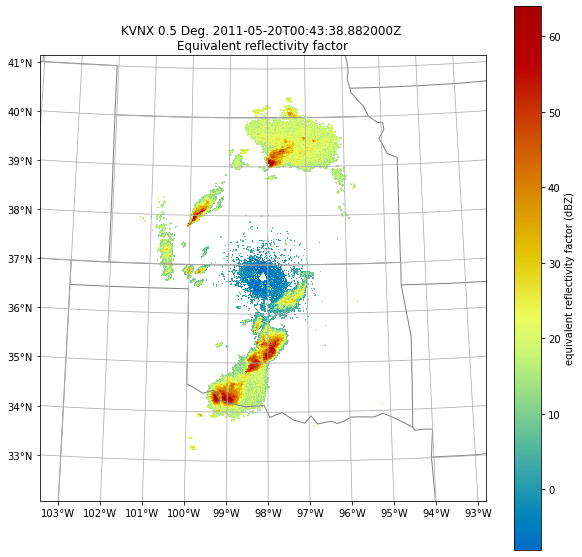

In [12]:
myf = plt.figure(figsize=[10,10])
myd = pyart.graph.RadarMapDisplay(radar)
myd.plot_ppi_map('reflectivity', 0, vmin=-8, vmax=64)

In [13]:
a=scans[-1]

In [14]:
a.scan_time

In [15]:
#https://stackoverflow.com/questions/32237862/find-the-closest-date-to-a-given-date/32237949
def nearest(items, pivot):
    return min(items, key=lambda x: abs(x - pivot))

In [25]:
times = [scan.scan_time for scan in scans]

#Need to clean
good_scans = []
good_times = []
for i in range(len(scans)):
    if times[i] is not None:
        good_times.append(times[i])
        good_scans.append(scans[i])
        
nearest_time = nearest(good_times, datetime(2011,5,20,11,6,55,0, pytz.UTC))


index = times.index(nearest_time)

In [26]:
index

153

In [27]:
def get_my_radar(connex, site, year, month, day, hour, minute, second):
    tlocation = tempfile.mkdtemp()
    these_scans = connex.get_avail_scans(year, month, day, site)
    these_times = [scan.scan_time for scan in these_scans]
    targ = datetime(year, month,day, hour, minute, second, 0, pytz.UTC)
    
    #Need to clean
    good_scans = []
    good_times = []
    for i in range(len(these_scans)):
        if these_times[i] is not None:
            good_times.append(these_times[i])
            good_scans.append(these_scans[i])

    this_nearest_time = nearest(good_times, targ)
    this_index = good_times.index(this_nearest_time)
    lcn = templocation
    localfiles = conn.download(good_scans[index],lcn)
    return pyart.io.read(localfiles.success[0].filepath)

In [29]:
#radar = get_my_radar('KLOT', 2021, 3, 9, 12, 0, 0)
#Some fun ones to try
#radar = get_my_radar('TJUA', 2017, 9, 6, 21, 48, 0)
radar = get_my_radar(conn, 'KVNX', 2011, 5, 20, 11, 6, 55)


None
Downloaded KVNX20110520_110651_V06.gz
1 out of 1 files downloaded...0 errors


/Users/scollis/miniconda3/envs/pyart-training/lib/python3.7/site-packages/cartopy/crs.py:2320: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  a = np.float(self.globe.semimajor_axis or WGS84_SEMIMAJOR_AXIS)
/Users/scollis/miniconda3/envs/pyart-training/lib/python3.7/site-packages/cartopy/crs.py:2321: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecati

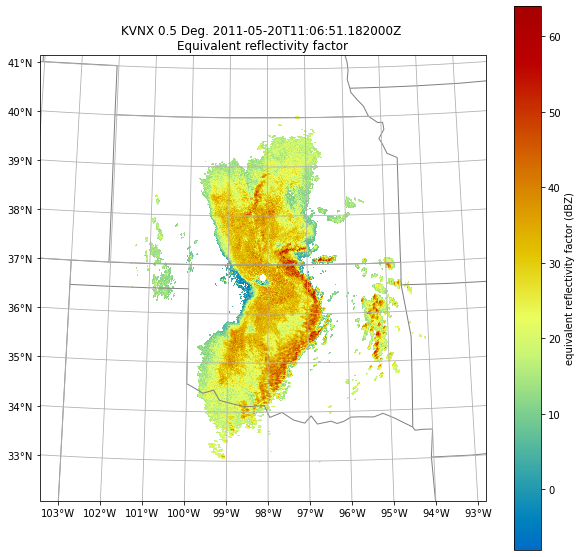

In [30]:
myf = plt.figure(figsize=[10,10])
myd = pyart.graph.RadarMapDisplay(radar)
myd.plot_ppi_map('reflectivity', 0, vmin=-8, vmax=64)

## So back to gridding

In [39]:
KVNX = get_my_radar(conn, 'KVNX', 2011, 5, 20, 11, 6, 0)
KTLX = get_my_radar(conn, 'KTLX', 2011, 5, 20, 11, 6, 0)
KINX = get_my_radar(conn, 'KINX', 2011, 5, 20, 11, 6, 0)


None
Downloaded KVNX20110520_110651_V06.gz
1 out of 1 files downloaded...0 errors
2011-05-20 23:57:16+00:00
Downloaded KTLX20110520_104316_V03.gz
1 out of 1 files downloaded...0 errors
2011-05-20 23:58:04+00:00
Downloaded KINX20110520_125150_V03.gz
1 out of 1 files downloaded...0 errors


In [43]:
grids = pyart.map.grid_from_radars((KINX, KVNX, KTLX),(16,401,401),
                   ((0.,15000.),(-400000.,400000.),(-400000.,400000.)),
                   refl_field='reflectivity', weighting_function='Barnes2')

In [44]:
xgrids = grids.to_xarray()

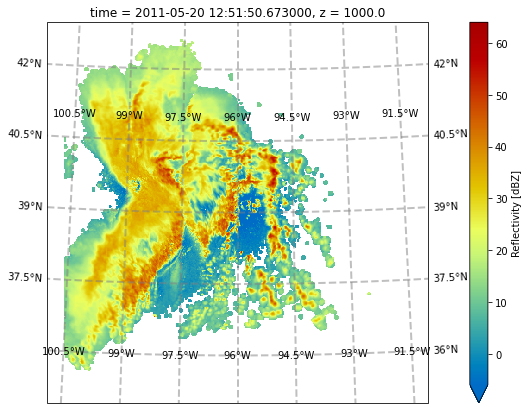

In [45]:
fig = plt.figure(figsize=[15, 7])
ax = plt.axes(projection=ccrs.LambertConformal())
pc = xgrids.reflectivity.sel(z=1000, 
                        time=xgrids.time[0]).plot.pcolormesh(cmap=pyart.graph.cm_colorblind.HomeyerRainbow, 
                                                             vmin=-6, vmax=64)
gl = ax.gridlines(draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')